In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
batch_size = 64
num_epochs = 20
learning_rate = 0.001
num_classes = 10

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


In [6]:
print("Loading CIFAR10 dataset...")
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)


Loading CIFAR10 dataset...


100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


In [7]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

In [8]:
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 50000
Test samples: 10000


Sample training images:


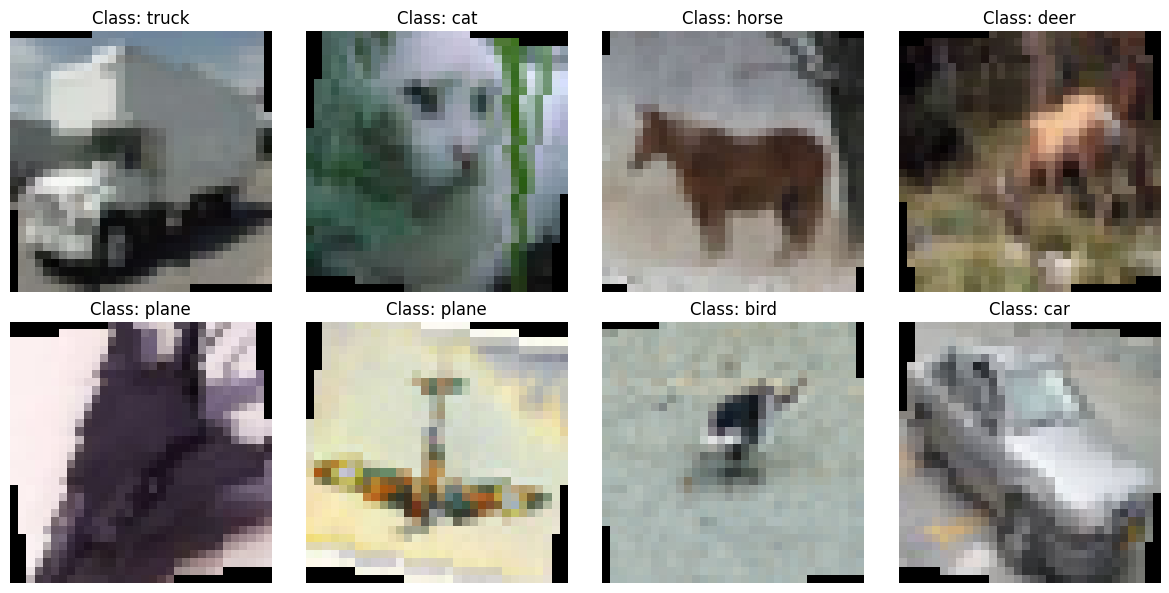

In [9]:
def visualize_samples(data_loader, num_samples=8):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)

    def denormalize(tensor):
        tensor = tensor * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        tensor = tensor + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        return torch.clamp(tensor, 0, 1)

    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)
        img = denormalize(images[i])
        img = img.permute(1, 2, 0)
        plt.imshow(img)
        plt.title(f'Class: {classes[labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample training images:")
visualize_samples(train_loader)

In [10]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.25)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x


In [11]:
model = CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
print("Model Architecture:")
print(model)

Model Architecture:
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3),

In [13]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')


Total parameters: 1,342,122
Trainable parameters: 1,342,122


In [14]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if (i + 1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] completed - '
              f'Average Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    return train_losses, train_accuracies


In [15]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    overall_accuracy = 100 * correct / total
    print(f'\nTest Accuracy: {overall_accuracy:.2f}%')

    print('\nPer-class accuracy:')
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {class_acc:.2f}%')

    return overall_accuracy


In [16]:
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs)


Starting training...
Epoch [1/20], Step [200/782], Loss: 1.7702, Accuracy: 30.32%
Epoch [1/20], Step [400/782], Loss: 1.5475, Accuracy: 34.64%
Epoch [1/20], Step [600/782], Loss: 1.4261, Accuracy: 37.12%
Epoch [1/20] completed - Average Loss: 1.6701, Accuracy: 38.91%
Epoch [2/20], Step [200/782], Loss: 1.4590, Accuracy: 46.85%
Epoch [2/20], Step [400/782], Loss: 1.2180, Accuracy: 47.79%
Epoch [2/20], Step [600/782], Loss: 1.1271, Accuracy: 48.98%
Epoch [2/20] completed - Average Loss: 1.3827, Accuracy: 49.95%
Epoch [3/20], Step [200/782], Loss: 1.3815, Accuracy: 54.59%
Epoch [3/20], Step [400/782], Loss: 1.2165, Accuracy: 55.64%
Epoch [3/20], Step [600/782], Loss: 1.0712, Accuracy: 56.28%
Epoch [3/20] completed - Average Loss: 1.2171, Accuracy: 56.83%
Epoch [4/20], Step [200/782], Loss: 1.1016, Accuracy: 60.38%
Epoch [4/20], Step [400/782], Loss: 1.2932, Accuracy: 60.18%
Epoch [4/20], Step [600/782], Loss: 1.0950, Accuracy: 60.58%
Epoch [4/20] completed - Average Loss: 1.1081, Accurac

In [17]:
print("\nTesting the model...")
test_accuracy = test_model(model, test_loader)


Testing the model...

Test Accuracy: 82.30%

Per-class accuracy:
plane: 85.10%
car: 94.90%
bird: 67.90%
cat: 61.90%
deer: 81.40%
dog: 79.30%
frog: 89.90%
horse: 85.00%
ship: 89.30%
truck: 88.30%


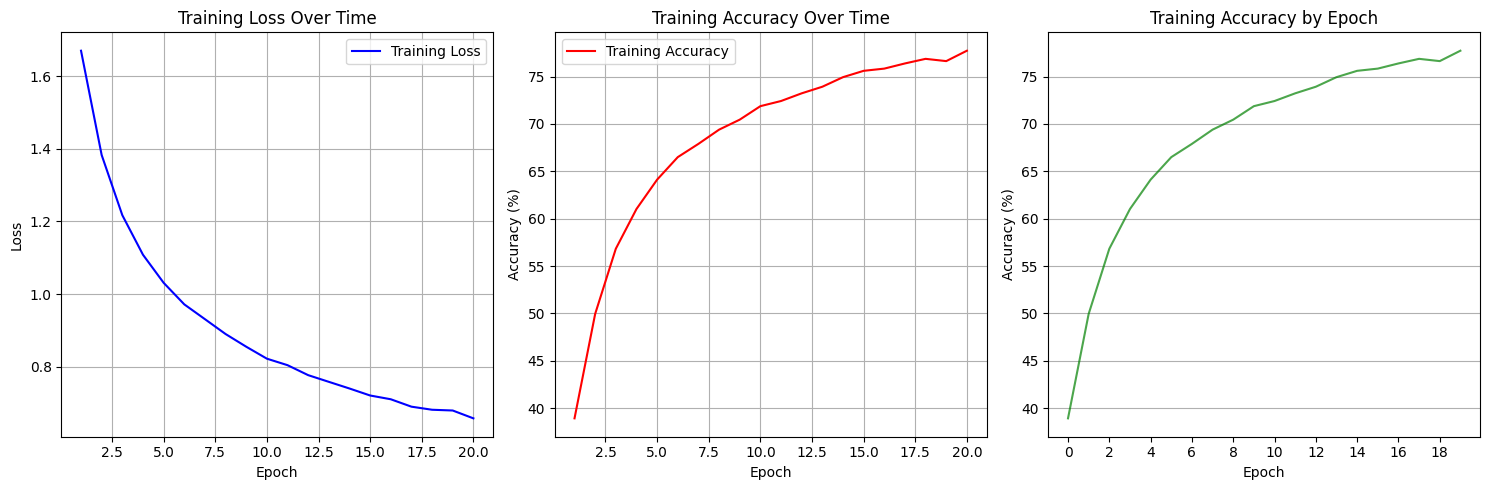

In [24]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, 'r-', label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Time')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), train_accuracies, alpha=0.7, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy by Epoch')
plt.xticks(range(0, num_epochs, 2))
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


In [19]:
def visualize_predictions(model, test_loader, num_samples=8):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = F.softmax(outputs, dim=1)

    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    probabilities = probabilities.cpu()

    def denormalize(tensor):
        tensor = tensor * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        tensor = tensor + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        return torch.clamp(tensor, 0, 1)

    plt.figure(figsize=(16, 8))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)
        img = denormalize(images[i])
        img = img.permute(1, 2, 0)
        plt.imshow(img)

        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        confidence = probabilities[i][predicted[i]] * 100

        color = 'green' if labels[i] == predicted[i] else 'red'
        plt.title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Sample predictions:


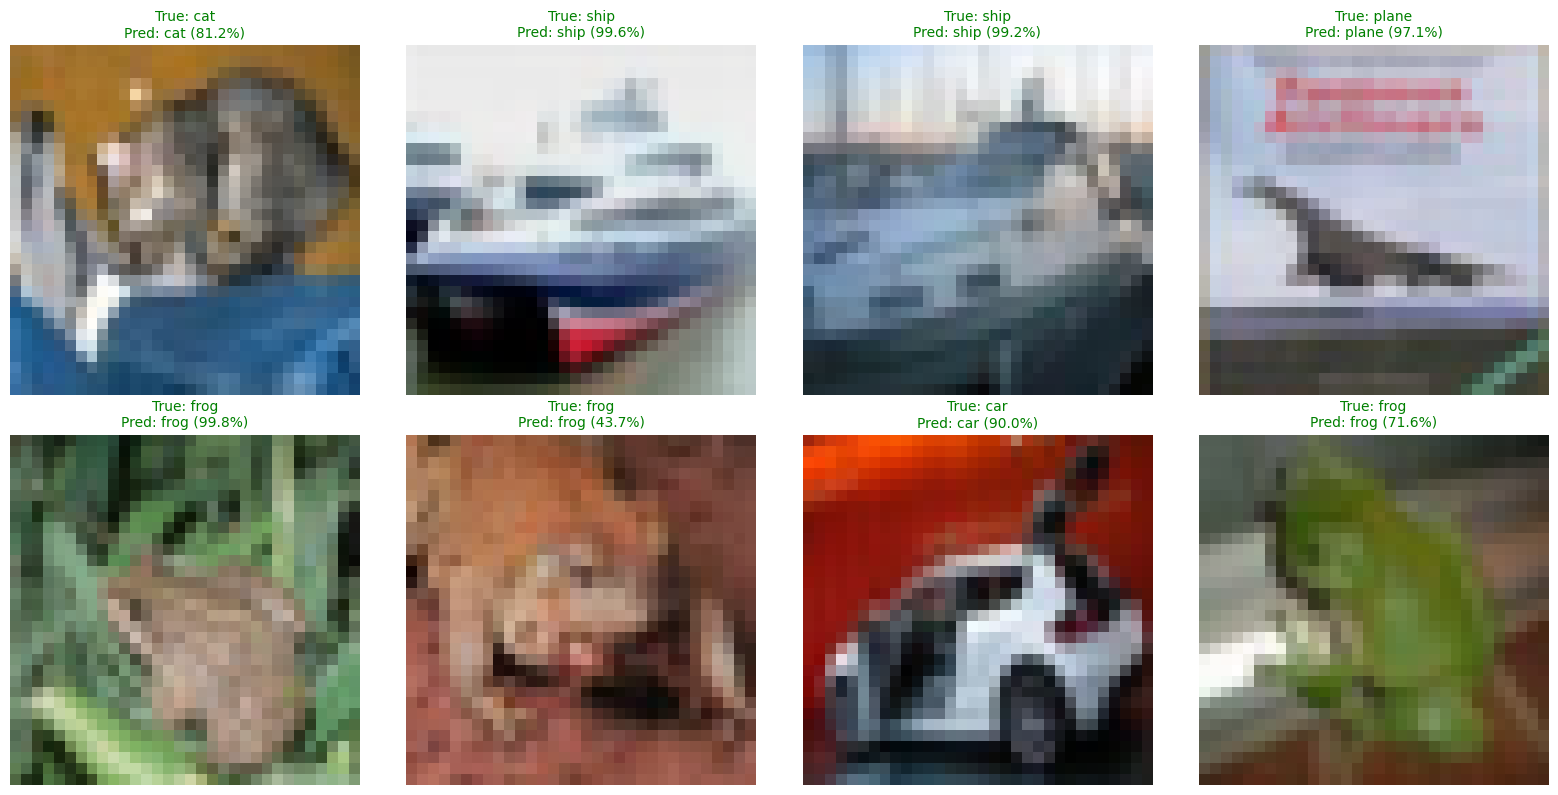

In [20]:
print("\nSample predictions:")
visualize_predictions(model, test_loader)

In [21]:
def visualize_feature_maps(model, test_loader):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    image = images[0:1].to(device)

    feature_maps = []

    def hook_fn(module, input, output):
        feature_maps.append(output)

    hooks = []
    hooks.append(model.conv1.register_forward_hook(hook_fn))
    hooks.append(model.conv3.register_forward_hook(hook_fn))
    hooks.append(model.conv5.register_forward_hook(hook_fn))

    with torch.no_grad():
        _ = model(image)

    for hook in hooks:
        hook.remove()

    fig, axes = plt.subplots(3, 8, figsize=(16, 6))
    fig.suptitle('Feature Maps from Different Layers', fontsize=16)

    layer_names = ['Conv1 (32 filters)', 'Conv3 (64 filters)', 'Conv5 (128 filters)']

    for layer_idx, (feature_map, layer_name) in enumerate(zip(feature_maps, layer_names)):
        feature_map = feature_map.cpu().squeeze(0)

        for i in range(8):
            ax = axes[layer_idx, i]
            if i < feature_map.shape[0]:
                ax.imshow(feature_map[i], cmap='gray')
            ax.set_title(f'{layer_name}\nFilter {i+1}', fontsize=8)
            ax.axis('off')

    plt.tight_layout()
    plt.show()



Visualizing feature maps:


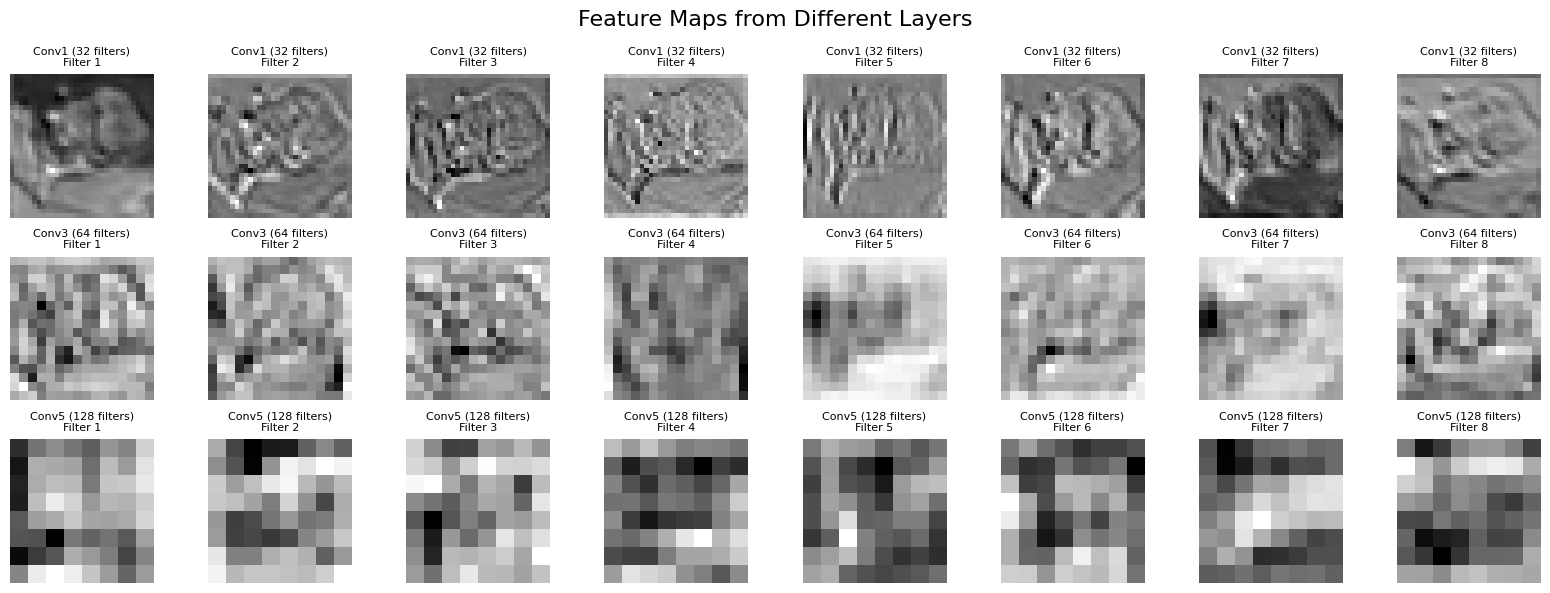

In [22]:
print("\nVisualizing feature maps:")
visualize_feature_maps(model, test_loader)

In [23]:
print(f"Final test accuracy: {test_accuracy:.2f}%")

Final test accuracy: 82.30%
